In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"imtoba","key":"e4c363cc45004995ac667e17b31d2e0a"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!mkdir -p data
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.04MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 130MB/s]
 99% 9.00M/9.10M [00:00<00:00, 71.4MB/s]
100% 9.10M/9.10M [00:00<00:00, 71.7MB/s]
 80% 63.0M/79.1M [00:00<00:00, 52.1MB/s]
100% 79.1M/79.1M [00:00<00:00, 130MB/s] 
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 62.7MB/s]
 97% 267M/276M [00:01<00:00, 205MB/s]
100% 276M/276M [00:01<00:00, 187MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 206MB/s]


In [0]:
!ls

data				  stage1_train_labels.csv.zip
sample_data			  stage1_train.zip
stage1_sample_submission.csv.zip  stage2_sample_submission_final.csv.zip
stage1_solution.csv.zip		  stage2_test_final.zip
stage1_test.zip


In [0]:
!mkdir stage1_train stage1_test

!unzip stage1_train.zip -d stage1_train/
!unzip stage1_test.zip -d stage1_test/

In [0]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K

Using TensorFlow backend.


In [0]:
smooth = 1.
epochs = 20


In [0]:
!ls 

data				  stage1_train
sample_data			  stage1_train_labels.csv.zip
stage1_sample_submission.csv.zip  stage1_train.zip
stage1_solution.csv.zip		  stage2_sample_submission_final.csv.zip
stage1_test			  stage2_test_final.zip
stage1_test.zip


In [0]:
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'


In [0]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]


In [0]:
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
    a = Progbar(len(train_ids))
    for n, id_ in enumerate(train_ids):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train

In [0]:
def read_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    if os.path.isfile("test_img.npy") and os.path.isfile("test_size.npy"):
        print("Test file loaded from memory")
        X_test = np.load("test_img.npy")
        sizes_test = np.load("test_size.npy")
        return X_test,sizes_test
    b = Progbar(len(test_ids))
    for n, id_ in enumerate(test_ids):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        b.update(n)
    np.save("test_img",X_test)
    np.save("test_size",sizes_test)
    return X_test,sizes_test


In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


In [0]:
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation= 'elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[dice_coef])
    model.summary()
    return model

In [0]:
train_img,train_mask = read_train_data()

test_img,test_img_sizes = read_test_data()

Getting and resizing train images and masks ... 
669/670 [============================>.] - ETA: 0s
Getting and resizing test images ... 
64/65 [============================>.] - ETA: 0s

In [0]:
u_net = get_unet()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
print("\nTraining...")
u_net.fit(train_img,train_mask,batch_size=16,epochs=epochs)


Training...
Epoch 1/20
670/670 [==============================] - 23s 35ms/step - loss: 0.3182 - dice_coef: 0.4145
Epoch 2/20
670/670 [==============================] - 14s 22ms/step - loss: 0.1316 - dice_coef: 0.7390
Epoch 3/20
670/670 [==============================] - 14s 22ms/step - loss: 0.1076 - dice_coef: 0.7987
Epoch 4/20
670/670 [==============================] - 15s 22ms/step - loss: 0.1012 - dice_coef: 0.8107
Epoch 5/20
670/670 [==============================] - 15s 22ms/step - loss: 0.0965 - dice_coef: 0.8191
Epoch 6/20
670/670 [==============================] - 15s 22ms/step - loss: 0.0972 - dice_coef: 0.8197
Epoch 7/20
670/670 [==============================] - 15s 22ms/step - loss: 0.0952 - dice_coef: 0.8221
Epoch 8/20
670/670 [==============================] - 15s 22ms/step - loss: 0.0896 - dice_coef: 0.8336
Epoch 9/20
670/670 [==============================] - 15s 22ms/step - loss: 0.0878 - dice_coef: 0.8341
Epoch 10/20
670/670 [==============================] - 15s 2

In [0]:
epochs=30

In [0]:
print("\nTraining...")
u_net.fit(train_img,train_mask,batch_size=16,epochs=epochs)


Training...
Epoch 1/30
670/670 [==============================] - 15s 22ms/step - loss: 0.0698 - dice_coef: 0.8666
Epoch 2/30
670/670 [==============================] - 15s 22ms/step - loss: 0.0680 - dice_coef: 0.8688
Epoch 3/30
670/670 [==============================] - 15s 22ms/step - loss: 0.0717 - dice_coef: 0.8615
Epoch 4/30
670/670 [==============================] - 15s 22ms/step - loss: 0.0706 - dice_coef: 0.8648
Epoch 5/30
670/670 [==============================] - 15s 22ms/step - loss: 0.0679 - dice_coef: 0.8671
Epoch 6/30
670/670 [==============================] - 15s 22ms/step - loss: 0.0663 - dice_coef: 0.8720
Epoch 7/30
670/670 [==============================] - 15s 22ms/step - loss: 0.0650 - dice_coef: 0.8730
Epoch 8/30
670/670 [==============================] - 15s 22ms/step - loss: 0.0648 - dice_coef: 0.8736
Epoch 9/30
670/670 [==============================] - 15s 22ms/step - loss: 0.0663 - dice_coef: 0.8717
Epoch 10/30
670/670 [==============================] - 15s 2

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


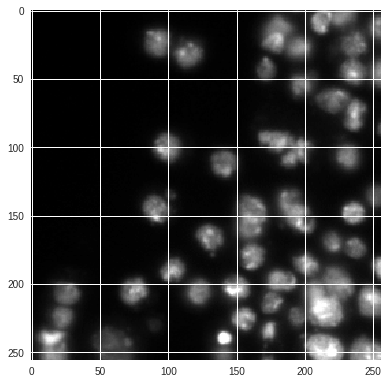

In [0]:
imshow( test_img[1] ) 

In [0]:
predum= u_net.predict(test_img,batch_size=6)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


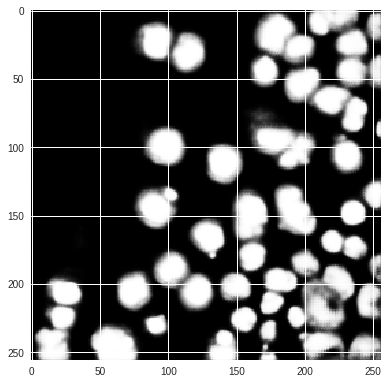

In [0]:

mg =np.squeeze( predum[1],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


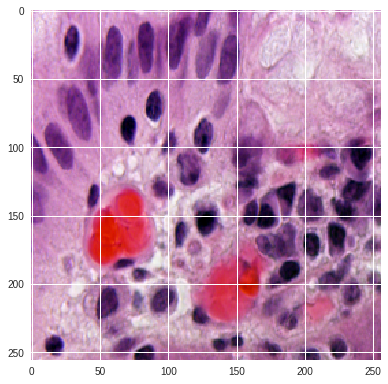

In [0]:
imshow( test_img[64] ) 

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


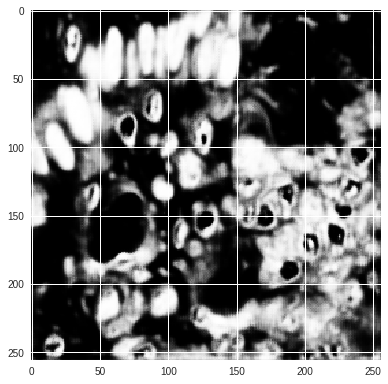

In [0]:
mg =np.squeeze( predum[64],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


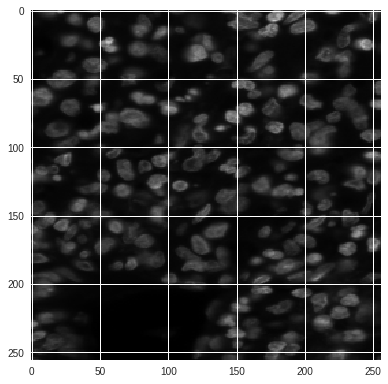

In [0]:
imshow( test_img[62] )

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


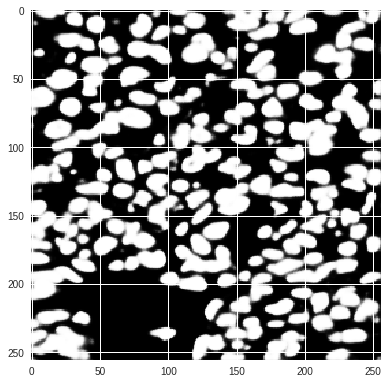

In [0]:
mg =np.squeeze( predum[62],axis=-1)
imshow(mg)

In [0]:
u_net.evaluate(x= test_img,y= predum )

65/65 [==============================] - 3s 44ms/step


[0.08262547621360192, 0.851044458609361]